In [23]:
import pycascades as pc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set(font_scale=1.5)
sns.set_style("white")

In [ ]:
runningMean = 0
runningStd = 0
regWindow = 25

def findAcRunning(cuspArray:np.ndarray, windowSize, minimumPoint, currentStartingPoint, stepSize,  AcArray:np.ndarray, slopeArray:np.ndarray, meanAcArray:np.ndarray, EwsVisible:np.ndarray):
    if(cuspArray.size < minimumPoint):
        return [0, 0, 0, 0]

    # so that the calculation of AC is smooth, need to step back full window and 
    # then start at the next step
            # only calculate the slope after passing the minimum point

    startingPoint = max(currentStartingPoint, minimumPoint-windowSize)
    slope = 0

    for i in range(startingPoint, cuspArray.size-windowSize, stepSize):
        currentWindow = cuspArray[i : i + windowSize]
        detrendedWindow = currentWindow - np.polyval(np.polyfit(np.arange(currentWindow.size)
            , currentWindow, 1), np.arange(currentWindow.shape[0]))

        prevWindow = detrendedWindow[:-1]
        nextWindow = detrendedWindow[1:]
        AcArray = np.append(AcArray, np.corrcoef(prevWindow, nextWindow)[0,1])

        slope = 0

        if(AcArray.size > regWindow):
            chunkAcArray = AcArray[AcArray.size - regWindow:]
            meanAcArray = np.append(meanAcArray, np.average(chunkAcArray))
            # x = np.reshape(np.arange(0, len(chunkAcArray), 1),(-1,1))
            # model = LinearRegression().fit(x, chunkAcArray)
            # slope = model.coef_
            # slopeArray = np.append(slopeArray, slope)

            runningMean = np.average(meanAcArray)
            runningStd = np.std(meanAcArray)
            if(meanAcArray[-1] > runningMean + .8 * runningStd):
                EwsVisible = np.append(EwsVisible, 1)
                if(meanAcArray[-1] > runningMean + 2 * runningStd):
                    EwsVisible = np.append(EwsVisible, 2)
            else: 
                EwsVisible = np.append(EwsVisible, 0)
    
    lastPoint = cuspArray.size - windowSize + stepSize


    return AcArray, slopeArray, lastPoint, slope, meanAcArray, EwsVisible

In [ ]:
timeSeries, cuspArray = np.array([]), np.array([])
EwsVisible = np.array([])
meanAcArray = np.array([])
initial_state = [0.0]

AcArray, slopeArray = np.array([]), np.array([])

windowSize = 1000       # the size of the window for sampling when calculating the Std
minimumPoint = 10000    # the starting point after which we start calculating running slope of Std
stepSize = 100          # how much the sampling window is shifted every iteration
lastPoint = 0           # record the last end index of the sampling window so the function picks up from 
                                # where it left off in last cycle and does not recalculate

for i,c in enumerate(np.linspace(0,0.5,100)) :
    cusp_element_0 = pc.cusp( a = -4, b = 1, c = c, x_0 = 0.5 )
    net = pc.tipping_network()
    net.add_element( cusp_element_0 )

    ev = pc.evolve_sde( net, initial_state )

    #Manually integrate the system
    timestep = 0.01
    t_end = 10

    #define sigma for random processes
    noise = 0.01						#noise level
    n = 1							#number of investigated tipping elements
    sigma = np.diag([1]*n)*noise	#diagonal uncorrelated noise
    ev.integrate( timestep, t_end, initial_state, sigma=sigma, noise = "normal")

    time = ev.get_timeseries()[0] + i * 10
    cusp = ev.get_timeseries()[1][:,0]

    timeSeries = np.append(timeSeries, time)
    cuspArray = np.append(cuspArray, cusp)

    if(cuspArray.size > minimumPoint + windowSize and lastPoint + (2 * windowSize) < cuspArray.size):
        AcArray, slopeArray, lastPoint, slopeFinal, meanAcArray, EwsVisible = findAcRunning(cuspArray, windowSize, minimumPoint, lastPoint, stepSize, AcArray, slopeArray, meanAcArray, EwsVisible)

    initial_state = [cusp[-1]]

In [ ]:
# calculate the running mean of the AcArray:
# meanAcArray = np.array([])
# meanWindow = 50
# for i in range(meanWindow, np.size(AcArray)-meanWindow):
#     meanAcArray = np.append(meanAcArray, np.average(AcArray[i-meanWindow:i+meanWindow]))

Text(0.5, 1.0, 'Autocorrelation With Running Mean')

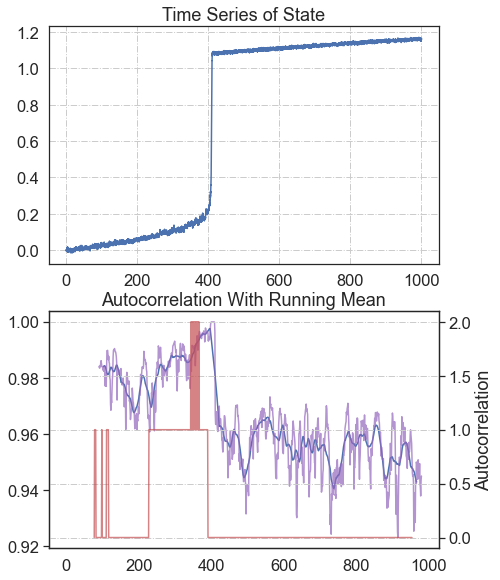

In [24]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(7, 9.6))

ax0.plot(timeSeries, cuspArray)
ax0.grid(True, linestyle='-.')
ax0.set_title('Time Series of State')


ax1.plot(meanAcArray, alpha=0)
ax1.plot(range(int(minimumPoint/100 - windowSize/100 + regWindow/2), np.size(meanAcArray)+int(minimumPoint/100 - windowSize/100 +regWindow/2)), meanAcArray, color ='b')
ax1.plot(range(int(minimumPoint/100 - windowSize/100), np.size(AcArray)+int(minimumPoint/100 - windowSize/100)), AcArray, color='tab:purple', alpha=0.7)


ax2=ax1.twinx()

ax2.plot(range(int(minimumPoint/100 - (windowSize/100 + regWindow/2)), np.size(EwsVisible)+int(minimumPoint/100 - (windowSize/100 + regWindow/2))), EwsVisible, color='r', alpha=0.7)
ax2.grid(True, linestyle='-.')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Autocorrelation')
ax2.set_title('Autocorrelation With Running Mean')



In [ ]:
output = []

output.append([[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]])
output.append([[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]])

data = np.array(output)

print(data.T[0])